In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count

# Initialize a Spark session
spark = SparkSession.builder.appName("LinkedInDataAnlysis").getOrCreate()

# Load the dataset
file_path = 'Final_merged_CA_output.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the first few rows of the dataframe and the schema
df.show(5)
df.printSchema()

# Count non-null values in each column
column_counts = df.agg(*[count(col).alias(col) for col in df.columns])

# Show the results
column_counts.show()

# Check for missing values in the dataset
missing_data = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

missing_data.show()


+----------+--------------------+-----------------+--------------------+---------+----------------+---------------+-------------------+--------------------+
|    job_id|           job_title|     company_name|    company_location|pay_range|       job_level|employment_type|    job_posted_date|            industry|
+----------+--------------------+-----------------+--------------------+---------+----------------+---------------+-------------------+--------------------+
|3999719407|Business Analyst-...|Zortech Solutions|              Canada|     NULL|       Associate|      Full-time|2024-08-13 14:33:42|Human Resources S...|
|3980031357|    Business Analyst|         delaPlex|              Canada|     NULL|Mid-Senior level|      Full-time|2024-07-16 14:33:43|IT Services and I...|
|3903816663|    Business Analyst|Zortech Solutions|Toronto, Ontario,...|     NULL|       Associate|      Full-time|2024-05-17 14:33:44|Human Resources S...|
|3994887179|    Business Analyst|             Onix|Greater

# Data Cleaning 

### Handling Missing Values

In [6]:
# Show missing data summary
missing_data.show()

# Drop columns with all missing values
jobs_df = df.dropna(how='all')

# Fill missing values with a placeholder (e.g., 0 for numeric columns)
jobs_df = jobs_df.fillna(0)

# Show the first few rows of the cleaned dataset
jobs_df.show(5)

+------+---------+------------+----------------+---------+---------+---------------+---------------+--------+
|job_id|job_title|company_name|company_location|pay_range|job_level|employment_type|job_posted_date|industry|
+------+---------+------------+----------------+---------+---------+---------------+---------------+--------+
|     0|        0|           0|               0|    57781|       27|              0|             82|      47|
+------+---------+------------+----------------+---------+---------+---------------+---------------+--------+

+----------+--------------------+-----------------+--------------------+---------+----------------+---------------+-------------------+--------------------+
|    job_id|           job_title|     company_name|    company_location|pay_range|       job_level|employment_type|    job_posted_date|            industry|
+----------+--------------------+-----------------+--------------------+---------+----------------+---------------+-------------------+

In [33]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("job_posted_date", to_timestamp(df["job_posted_date"], "yyyy-MM-dd HH:mm:ss"))
df.printSchema()


root
 |-- job_id: long (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_location: string (nullable = true)
 |-- pay_range: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_posted_date: timestamp (nullable = true)
 |-- industry: string (nullable = true)



### Dropping Duplicates

In [11]:
# Check for duplicates
duplicate_count = jobs_df.count() - jobs_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 73


In [35]:
# View column names
print(jobs_df.columns)

['job_id', 'job_title', 'company_name', 'company_location', 'pay_range', 'job_level', 'employment_type', 'job_posted_date', 'industry']


In [34]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("data_table")

In [36]:
from pyspark.sql.functions import count

# SQL query to find duplicate rows based on all columns
duplicate_rows = spark.sql("""
    SELECT job_id, job_title, company_name, company_location, pay_range, job_level, employment_type, job_posted_date, industry, COUNT(*) as count
    FROM data_table
    GROUP BY job_id, job_title, company_name, company_location, pay_range, job_level, employment_type, job_posted_date, industry
    HAVING COUNT(*) > 1
    ORDER BY job_id
""")


# Show the duplicate rows
duplicate_rows.show()

+----------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+-------------------+--------------------+-----+
|    job_id|           job_title|        company_name|    company_location|           pay_range|       job_level|employment_type|    job_posted_date|            industry|count|
+----------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+-------------------+--------------------+-----+
|3948032962|    Business Analyst|                 CAE|Montreal, Quebec,...|                NULL|  Not Applicable|      Full-time|               NULL|Aviation and Aero...|   14|
|3980491887|Data Engineer, Sc...|          Scotiabank|Toronto, Ontario,...|                NULL|  Not Applicable|      Full-time|2024-08-10 15:12:23|             Banking|    2|
|3980491887|Data Engineer, Sc...|          Scotiabank|Toronto, Ontario,...|                NULL|  Not Applicable|  

In [17]:
# Drop duplicates
jobs_df = jobs_df.dropDuplicates()

In [103]:
# Count non-null values in each column
column_counts = jobs_df.agg(*[count(col).alias(col) for col in jobs_df.columns])

# Show the results
column_counts.show()

+------+---------+------------+----------------+---------+---------+---------------+---------------+--------+
|job_id|job_title|company_name|company_location|pay_range|job_level|employment_type|job_posted_date|industry|
+------+---------+------------+----------------+---------+---------+---------------+---------------+--------+
| 61120|    61120|       61120|           61120|     3399|    61093|          61120|          61107|   61073|
+------+---------+------------+----------------+---------+---------+---------------+---------------+--------+



# Using Spark SQL

In [18]:
spark.sql("""
select count(distinct job_title) from data_table
""").show()

+-------------------------+
|count(DISTINCT job_title)|
+-------------------------+
|                     2043|
+-------------------------+



In [42]:
spark.sql("""
select distinct to_date(job_posted_date, 'yyyy-MM') as date, count(*) from data_table
group by to_date(job_posted_date, 'yyyy-MM')
order by 1 desc
""").show()

+----------+--------+
|      date|count(1)|
+----------+--------+
|2024-08-15|     689|
|2024-08-14|    3697|
|2024-08-13|    4005|
|2024-08-12|     508|
|2024-08-11|     534|
|2024-08-10|    2084|
|2024-08-09|    2764|
|2024-08-08|    4566|
|2024-08-07|    6337|
|2024-08-06|    1221|
|2024-08-01|    2425|
|2024-07-31|    3329|
|2024-07-30|     695|
|2024-07-25|    1228|
|2024-07-24|    2202|
|2024-07-23|     357|
|2024-07-18|     179|
|2024-07-17|     479|
|2024-07-16|    1839|
|2024-07-15|    3243|
+----------+--------+
only showing top 20 rows



In [104]:
# Convert the Spark DataFrame to Pandas DataFrame for visualization
jobs_pd_df = jobs_df.toPandas()

In [195]:
# Get the count of non-null values in each column
column_counts = jobs_pd_df.count()

# Display the total count for each column
column_counts

job_id              61120
job_title           61120
company_name        61120
company_location    61120
pay_range            3372
job_level           61120
employment_type     61120
job_posted_date     61107
industry            61073
City                61120
State               52348
Country             55034
YearMonth           61107
dtype: int64

In [183]:
# Load the new CSV file into a pandas DataFrame
jobs_pd_df = pd.read_csv('Final_merged_CA_output.csv')

# Remove duplicates
jobs_pd_df = jobs_pd_df.drop_duplicates()

# Display the first few rows of the cleaned DataFrame
jobs_pd_df.head()

,job_id,job_title,company_name,company_location,pay_range,job_level,employment_type,job_posted_date,industry
0,3999719407,Business Analyst-RPA-Canada,Zortech Solutions,Canada,NaN,Associate,Full-time,2024-08-13 14:33:42,Human Resources Services
1,3980031357,Business Analyst,delaPlex,Canada,NaN,Mid-Senior level,Full-time,2024-07-16 14:33:43,IT Services and IT Consulting
2,3903816663,Business Analyst,Zortech Solutions,"Toronto, Ontario, Canada",NaN,Associate,Full-time,2024-05-17 14:33:44,Human Resources Services
3,3994887179,Business Analyst,Onix,"Greater Toronto Area, Canada",NaN,Mid-Senior level,Full-time,2024-08-10 14:33:44,IT Services and IT Consulting
4,3948516566,Business Analyst-RPA - Canada,Zortech Solutions,Canada,NaN,Associate,Contract,2024-06-16 14:33:45,Human Resources Services


# Machine Learning Model

### Random Forest Model

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Drop columns that are not useful for prediction or have too many missing values
data_cleaned = jobs_pd_df.drop(columns=['job_id', 'pay_range', 'job_posted_date'])

In [122]:
# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in jobs_pd_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    jobs_pd_df[column] = le.fit_transform(jobs_pd_df[column])
    label_encoders[column] = le

# Separate features (X) and target (y)
X = jobs_pd_df.drop('job_level', axis=1)
y = jobs_pd_df['job_level']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Re-evaluating the model with adjusted classification report

# Get the unique classes from the target variable
unique_classes = y.unique()

# Regenerate the classification report with correct labels
classification_rep = classification_report(y_test, y_pred, labels=unique_classes)

accuracy, classification_rep

(0.9991819371727748,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       809\n           5       1.00      1.00      1.00      4775\n           2       1.00      1.00      1.00      4991\n           6       1.00      1.00      1.00      1483\n           1       1.00      1.00      1.00        68\n           4       1.00      1.00      1.00        77\n           3       1.00      1.00      1.00        21\n\n    accuracy                           1.00     12224\n   macro avg       1.00      1.00      1.00     12224\nweighted avg       1.00      1.00      1.00     12224\n')

### Gradient Boosting Classifier

In [194]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Assuming X and y are your features and labels
# Split the data into training and testing sets (if not already split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in the training set
print("Class distribution in training set:", np.bincount(y_train))

# Applying SMOTE to balance the dataset with adjusted k_neighbors
smallest_class_size = np.min(np.bincount(y_train))
k_neighbors = max(1, min(5, smallest_class_size - 1))  # Ensure k_neighbors is at least 1 and not greater than 5

smote = SMOTE(k_neighbors=k_neighbors, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(gb_classifier, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best model from GridSearch
best_gb_classifier = grid_search.best_estimator_

# Predictions and evaluation
y_pred_gb = best_gb_classifier.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb, labels=np.unique(y_test))

print("Accuracy of Gradient Boosting Classifier:", accuracy_gb)
print("Classification Report:\n", classification_rep_gb)


Class distribution in training set: [ 3284   298 19645    81   265 19486  5837]
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Accuracy of Gradient Boosting Classifier: 0.9965641361256544
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       809
           1       1.00      1.00      1.00        68
           2       1.00      0.99      1.00      4991
           3       1.00      1.00      1.00        21
           4       0.99      1.00      0.99        77
           5       0.99      1.00      1.00      4775
           6       1.00      1.00      1.00      1483

    accuracy                           1.00     12224
   macro avg       1.00      1.00      1.00     12224
weighted avg       1.00      1.00      1.00     12224



# Data Visulaization

### Job Postings Over Time

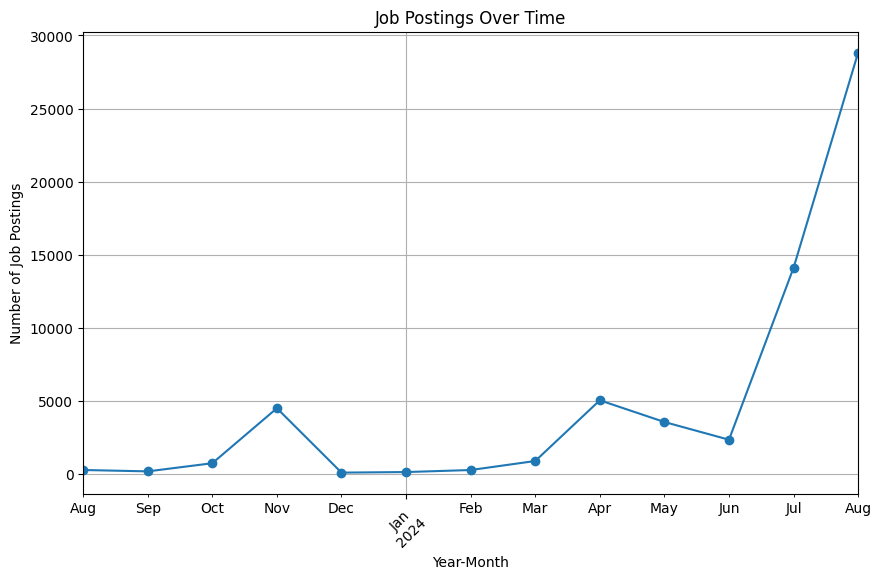

In [129]:
import matplotlib.pyplot as plt

# Convert the job_posted_date to datetime format
jobs_pd_df['job_posted_date'] = pd.to_datetime(jobs_pd_df['job_posted_date'])

# Extract year and month for trend analysis
jobs_pd_df['year_month'] = jobs_pd_df['job_posted_date'].dt.to_period('M')

plt.figure(figsize=(10, 6))
jobs_pd_df.groupby('year_month').size().plot(kind='line', marker='o')
plt.title('Job Postings Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Exploring top companies by job level

<Figure size 1400x800 with 0 Axes>

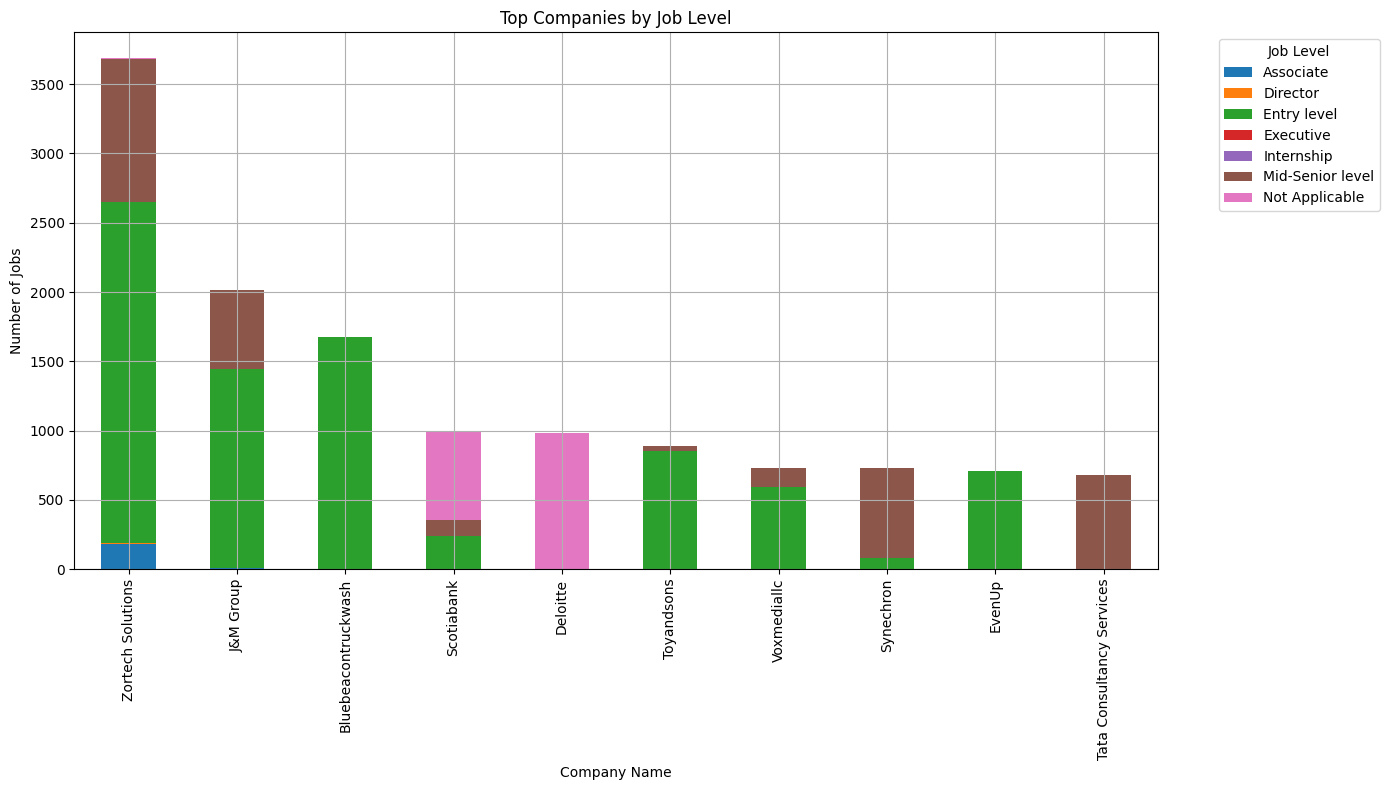

In [130]:


# Analyze the top companies by job level
top_companies_by_job_level = jobs_pd_df.groupby(['company_name', 'job_level']).size().unstack(fill_value=0)

# Sort the data to show companies with the most positions in descending order
top_companies_sorted = top_companies_by_job_level.sum(axis=1).sort_values(ascending=False).head(10)
top_companies_by_job_level = top_companies_by_job_level.loc[top_companies_sorted.index]

# Plot the data
plt.figure(figsize=(14, 8))
top_companies_by_job_level.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Top Companies by Job Level')
plt.xlabel('Company Name')
plt.ylabel('Number of Jobs')
plt.legend(title='Job Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Job Level Distribution by Top 10 Industries

<Figure size 1400x800 with 0 Axes>

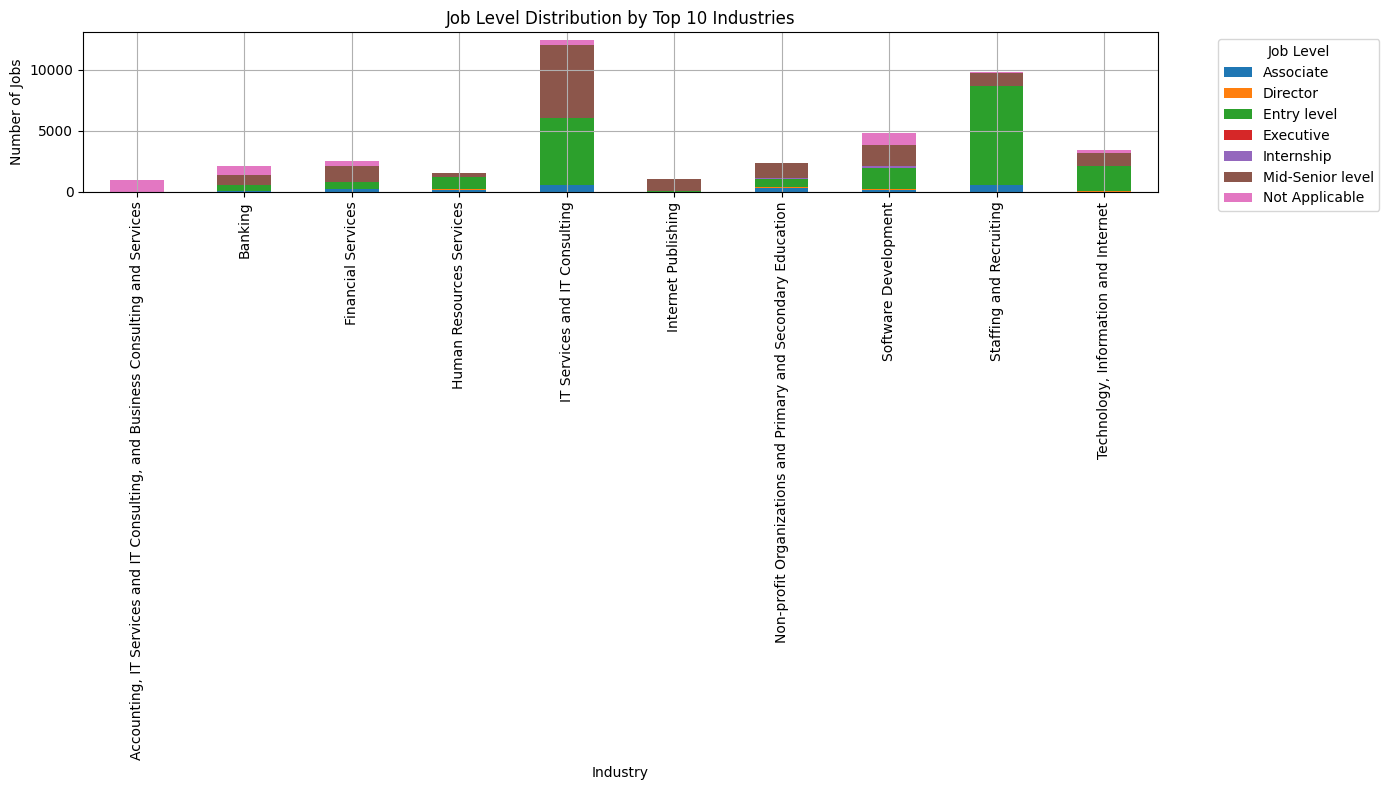

In [139]:
# Analyze the job level distribution by the top 10 industries with the most job postings
top_industries = jobs_pd_df['industry'].value_counts().head(10).index
# print(top_industries)

job_level_by_top_industry = jobs_pd_df[jobs_pd_df['industry'].isin(top_industries)].groupby(['industry', 'job_level']).size().unstack(fill_value=0)

# print(job_level_by_top_industry)

# Plot the data
plt.figure(figsize=(14, 8))
job_level_by_top_industry.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Job Level Distribution by Top 10 Industries')
plt.xlabel('Industry')
plt.ylabel('Number of Jobs')
plt.legend(title='Job Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [132]:
# Find the industry offering the most internships
internship_counts = jobs_pd_df[jobs_pd_df['job_level'] == 'Internship'].groupby('industry').size()

# Identify the industry with the maximum number of internships
top_internship_industry = internship_counts.idxmax()
top_internship_count = internship_counts.max()

top_internship_industry, top_internship_count


('Software Development', 178)

### Distribution of Internships by Industry and Company

industry
Software Development                                                                  178
Investment Management                                                                  27
Software Development, Financial Services, and Technology, Information and Internet     27
Non-profit Organizations and Primary and Secondary Education                           22
Financial Services and Investment Management                                           20
Higher Education                                                                       18
Semiconductor Manufacturing                                                            16
Appliances, Electrical, and Electronics Manufacturing                                  14
Education, Business Consulting and Services, and Data Infrastructure and Analytics     11
Wholesale                                                                               6
Telecommunications                                                                      2
F

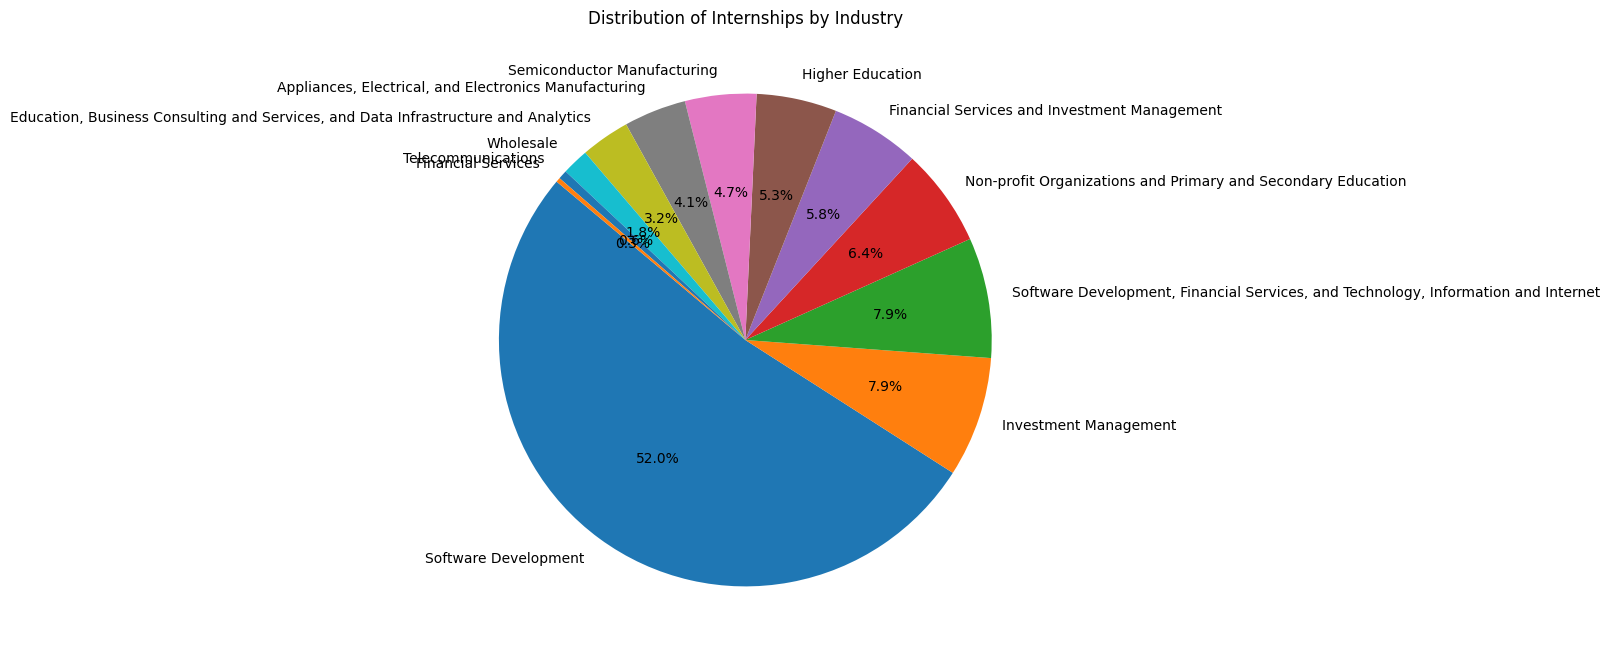

company_name
Kinaxis                                              68
Klue                                                 50
Lumerate                                             48
CPP Investments | Investissements RPC                27
Stripe                                               27
DataVisor                                            22
Alberta Investment Management Corporation (AIMCo)    20
NOSM University | Université EMNO                    18
Intel Corporation                                    16
Hammond Power Solutions                              14
Asana                                                12
Refonte Learning                                     11
Federated Co-operatives Limited                       6
Huawei Canada                                         2
Capital One                                           1
Name: count, dtype: int64


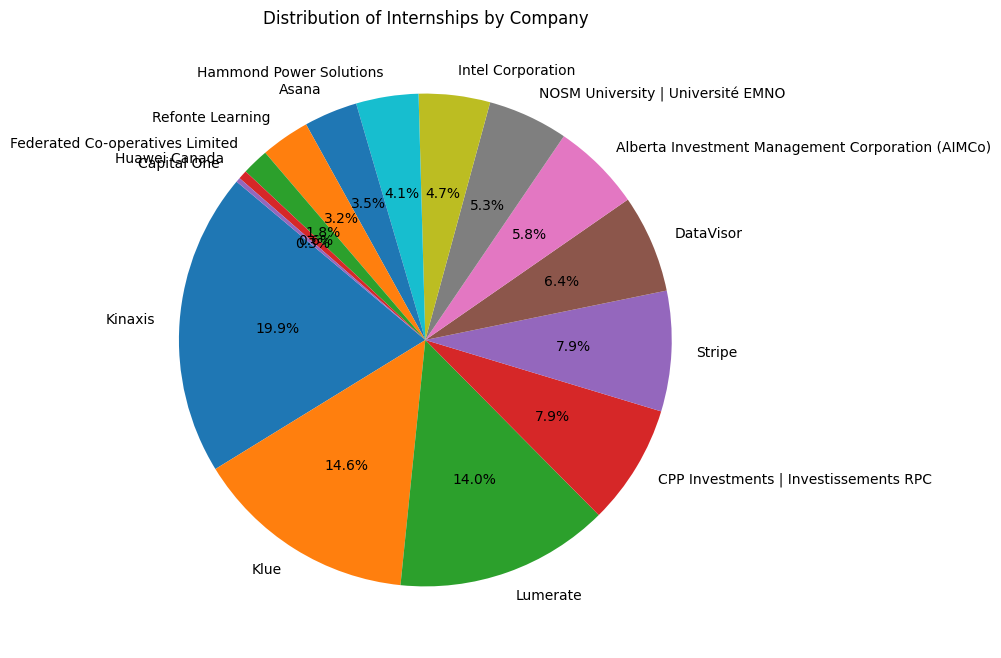

In [133]:


# Filter the dataset to include only internship-level jobs
internship_jobs = jobs_pd_df[jobs_pd_df['job_level'] == 'Internship']

# Distribution of internships by industry
industry_distribution = internship_jobs['industry'].value_counts()
print(industry_distribution)

# Plotting the pie chart for industry distribution
plt.figure(figsize=(10, 8))
plt.pie(industry_distribution, labels=industry_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Internships by Industry')
plt.show()

# Distribution of internships by company
company_distribution = internship_jobs['company_name'].value_counts()
print(company_distribution)

# Plotting the pie chart for company distribution
plt.figure(figsize=(10, 8))
plt.pie(company_distribution, labels=company_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Internships by Company')
plt.show()

### Distribution of Employment Types

employment_type
Full-time     49948
Contract      10097
Temporary       426
Other           253
Internship      220
Part-time       176
Name: count, dtype: int64


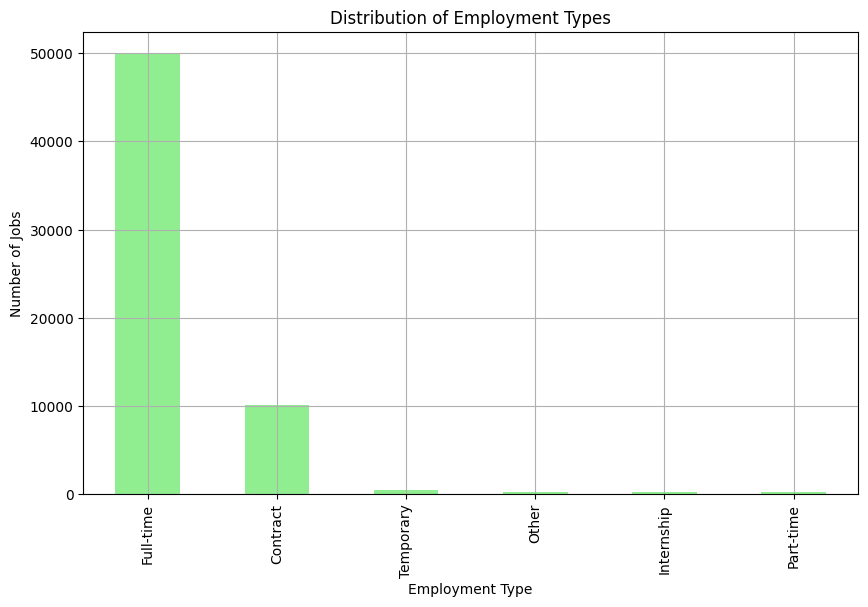

In [134]:
# Analyze the distribution of employment types
employment_type_distribution = jobs_pd_df['employment_type'].value_counts()

print(employment_type_distribution)

# Plotting the distribution
plt.figure(figsize=(10, 6))
employment_type_distribution.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Number of Jobs')
plt.grid(True)
plt.show()


### Most Common Job Titles

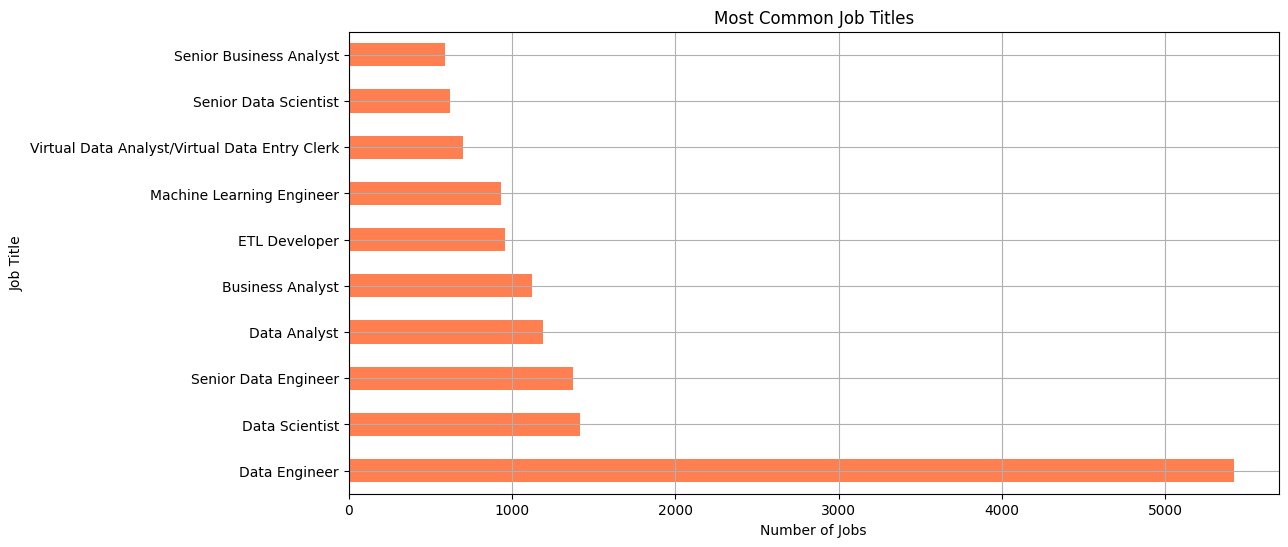

In [135]:
# Analyze the most common job titles
common_job_titles = jobs_pd_df['job_title'].value_counts().head(10)
# print(common_job_titles)

# Plotting the most common job titles using a horizontal bar chart
plt.figure(figsize=(12, 6))
common_job_titles.plot(kind='barh', color='coral')
plt.title('Most Common Job Titles')
plt.xlabel('Number of Jobs')
plt.ylabel('Job Title')
plt.grid(True)
plt.show()


### Top 20 Industry Distribution for Data Engineers

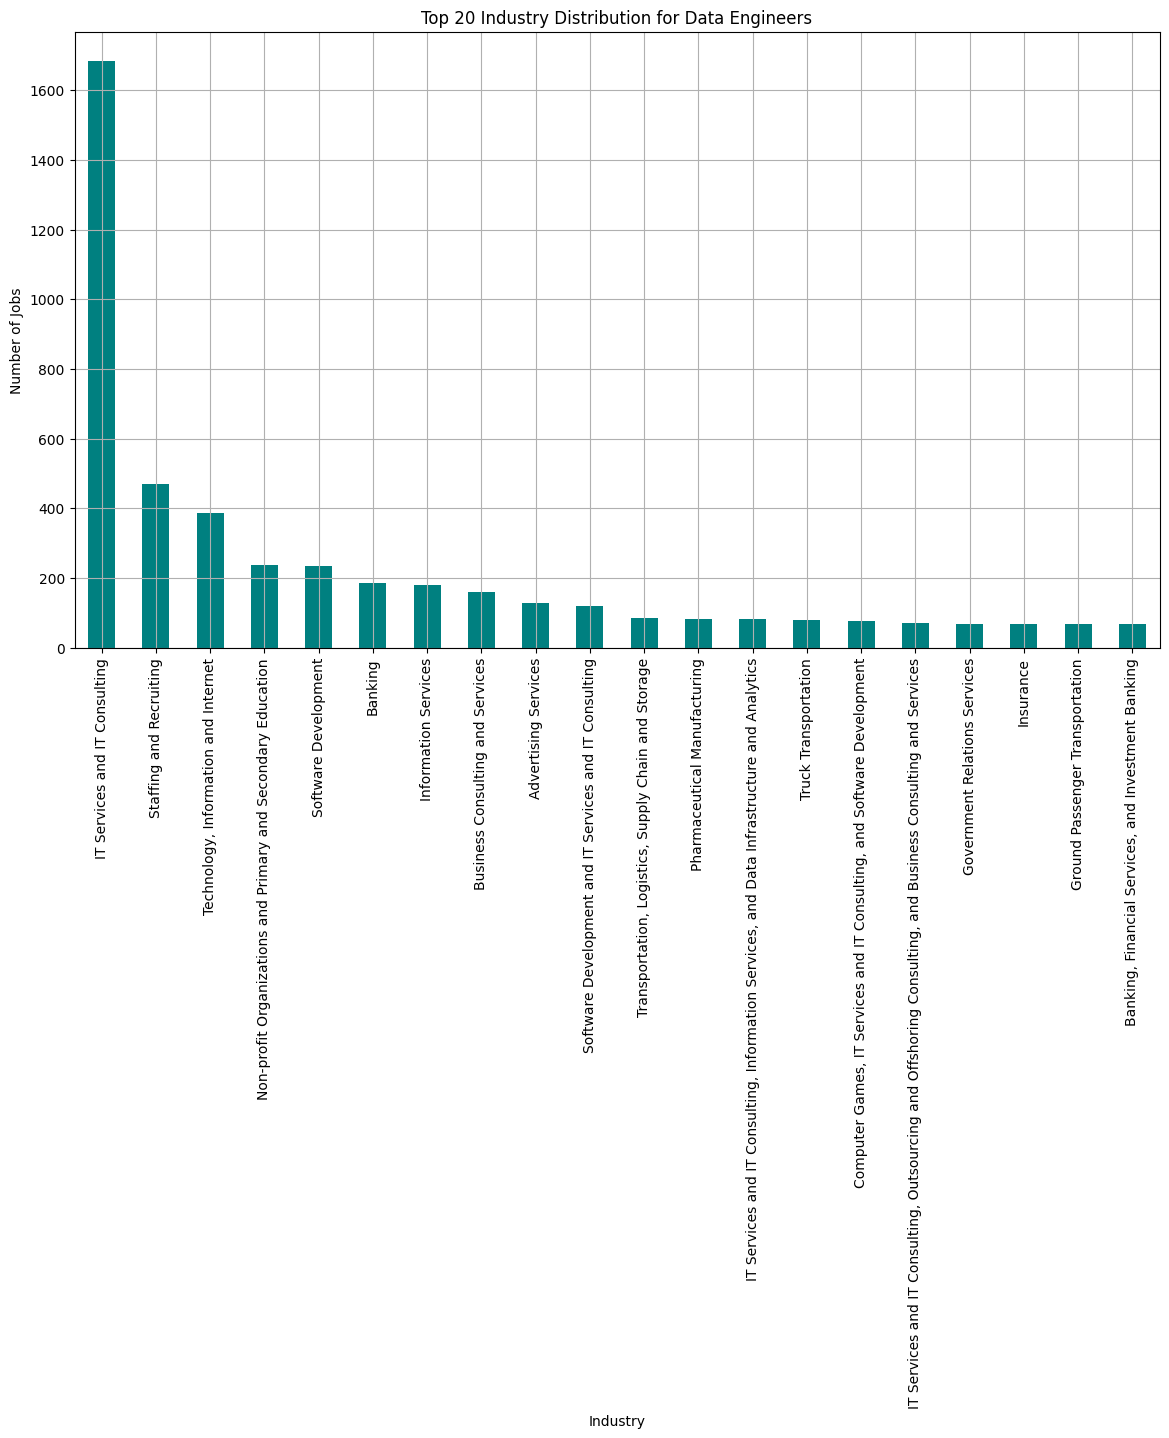

In [140]:
# Filter the dataset to include only "Data Engineer" job titles
data_engineer_jobs = jobs_pd_df[jobs_pd_df['job_title'] == 'Data Engineer']

# Analyze the top 20 industries where Data Engineer positions are most common
top_industries_for_data_engineers = data_engineer_jobs['industry'].value_counts().head(20)

# Plotting the distribution for the top 20 industries
plt.figure(figsize=(14, 8))
top_industries_for_data_engineers.plot(kind='bar', color='teal')
plt.title('Top 20 Industry Distribution for Data Engineers')
plt.xlabel('Industry')
plt.ylabel('Number of Jobs')
plt.grid(True)
plt.show()


### Most Common Job Titles by Location

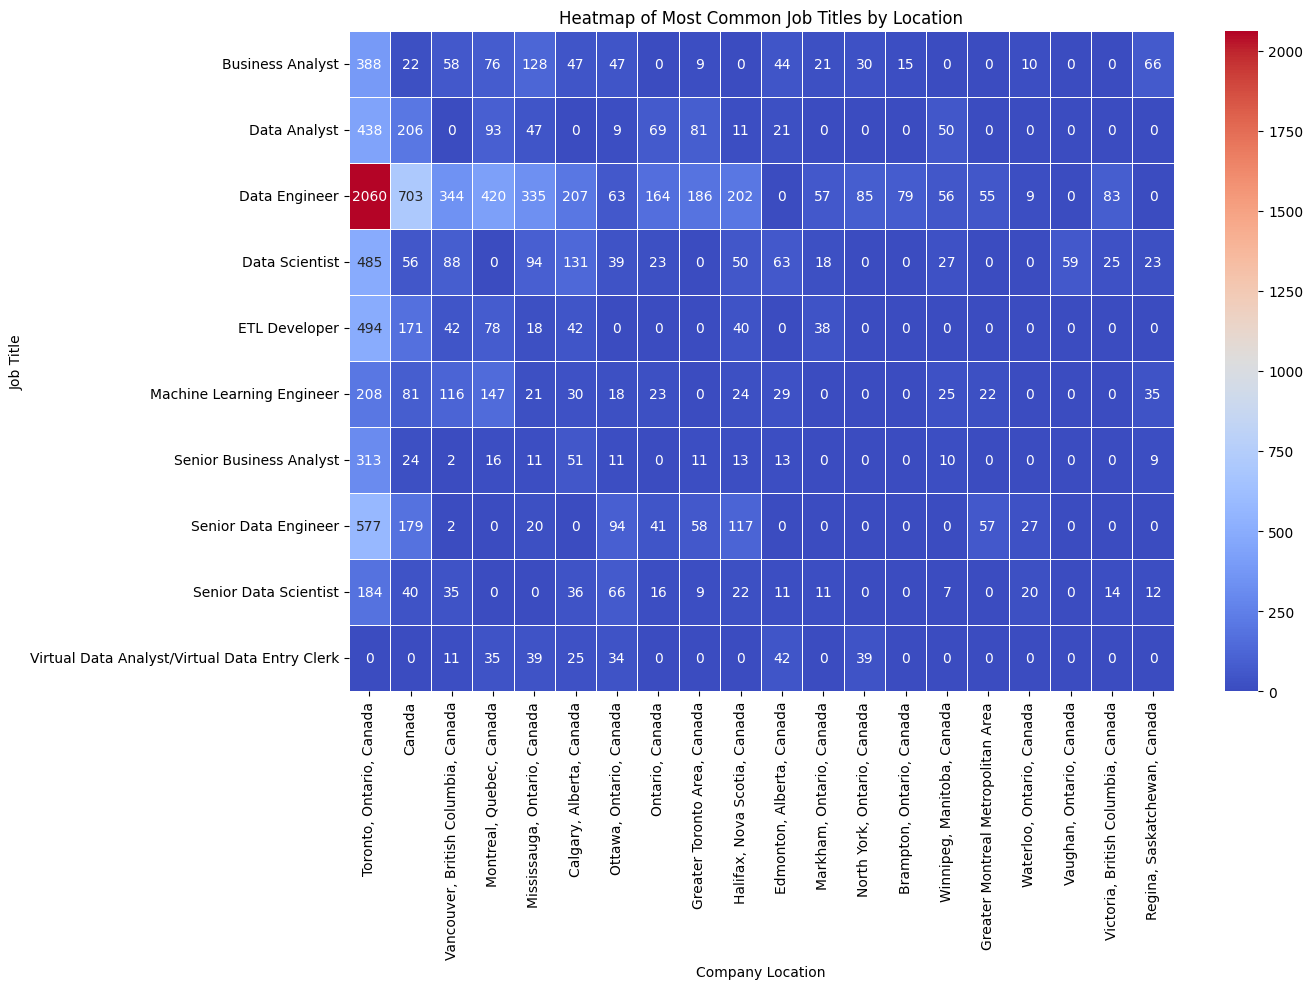

In [141]:
import seaborn as sns
# Analyze the distribution of job postings by company location
job_postings_by_location = jobs_pd_df['company_location'].value_counts().head(20)

# Filter the dataset for the most common job titles
common_titles = common_job_titles.index.tolist()
filtered_jobs = jobs_pd_df[jobs_pd_df['job_title'].isin(common_titles)]

# Analyze the distribution of these job titles by location
job_titles_by_location = pd.crosstab(filtered_jobs['company_location'], filtered_jobs['job_title'])

# Focus on the top locations
top_locations = job_postings_by_location.index.tolist()
job_titles_by_location = job_titles_by_location.loc[top_locations]

# To create a heatmap, let's use the crosstab of job titles by locations
plt.figure(figsize=(14, 10))
sns.heatmap(job_titles_by_location.T, cmap='coolwarm', annot=True, fmt="d", linewidths=.5)
plt.title('Heatmap of Most Common Job Titles by Location')
plt.xlabel('Company Location')
plt.ylabel('Job Title')
plt.tight_layout()

# Show the heatmap
plt.show()


### Distribution of Top 20 Job Titles by Industry

<Figure size 1400x1000 with 0 Axes>

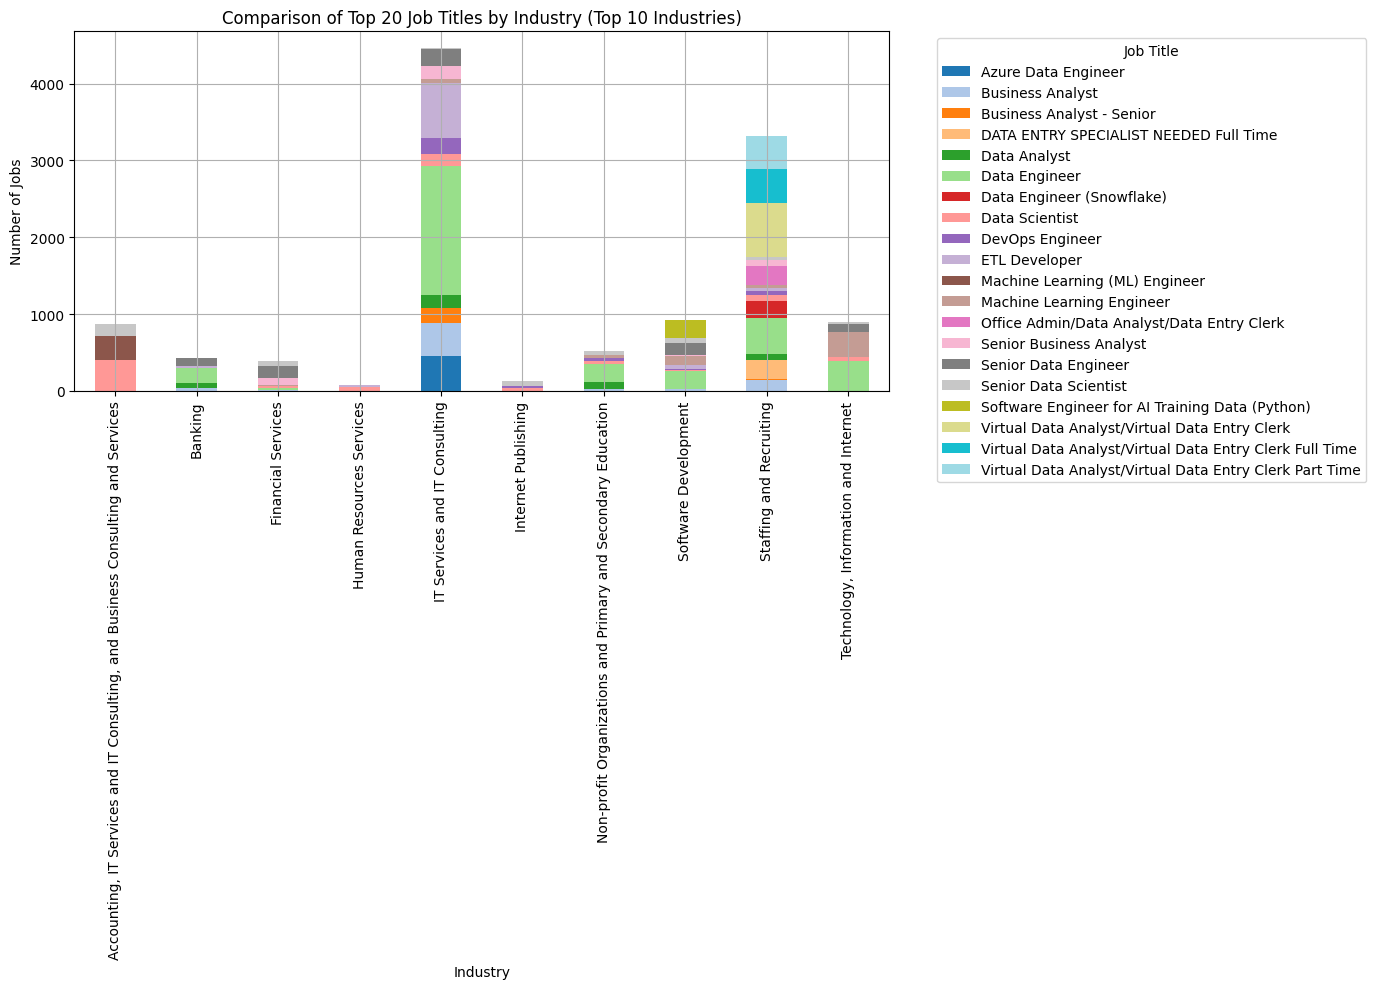

In [142]:
# Filter the dataset to focus on the most common industries
top_industries = jobs_pd_df['industry'].value_counts().head(10).index.tolist()
filtered_industries_jobs = jobs_pd_df[jobs_pd_df['industry'].isin(top_industries)]

# Analyze the distribution of job titles within these industries, focusing on the top 20 job titles
top_job_titles = filtered_industries_jobs['job_title'].value_counts().head(20).index.tolist()
filtered_jobs = filtered_industries_jobs[filtered_industries_jobs['job_title'].isin(top_job_titles)]

# Create a crosstab for job titles by industry
job_titles_by_industry = pd.crosstab(filtered_jobs['industry'], filtered_jobs['job_title'])

# Plot the comparison using a stacked bar chart
plt.figure(figsize=(14, 10))
job_titles_by_industry.plot(kind='bar', stacked=True, figsize=(14, 10), colormap='tab20')
plt.title('Comparison of Top 20 Job Titles by Industry (Top 10 Industries)')
plt.xlabel('Industry')
plt.ylabel('Number of Jobs')
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the combined plot
plt.show()


### Distribution of Average Pay Ranges

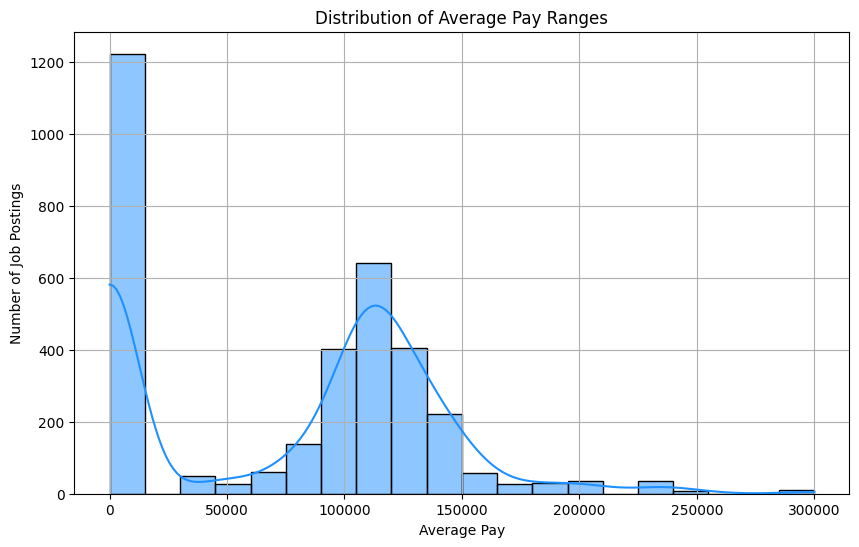

In [143]:
import re
import numpy as np

# Function to extract the average pay from the pay range
def extract_avg_pay(pay_range):
    if pd.isna(pay_range):
        return np.nan
    # Extract numbers from the string using regex
    amounts = re.findall(r'\d+(?:,\d+)*\.?\d*', pay_range)
    amounts = [float(amount.replace(',', '')) for amount in amounts]
    if len(amounts) == 2:
        return np.mean(amounts)  # Return the average of the range
    elif len(amounts) == 1:
        return amounts[0]  # If there's only one number, return it
    return np.nan

# Apply the function to the 'pay_range' column
jobs_pd_df['avg_pay'] = jobs_pd_df['pay_range'].apply(extract_avg_pay)

# Drop NaN values in the 'avg_pay' column for the analysis
jobs_pd_df = jobs_pd_df.dropna(subset=['avg_pay'])

# Display the first few rows of the processed column
jobs_pd_df[['pay_range', 'avg_pay']].head()

plt.figure(figsize=(10, 6))
sns.histplot(jobs_pd_df['avg_pay'], bins=20, kde=True, color='dodgerblue')
plt.title('Distribution of Average Pay Ranges')
plt.xlabel('Average Pay')
plt.ylabel('Number of Job Postings')
plt.grid(True)
plt.show()


In [82]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/9.8 MB 5.0 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.8 MB 7.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/9.8 MB 8.6 MB/s eta 0:00:01
   ------- -------------------------------- 2.0/9.8 MB 9.6 MB/s eta 0:00:01
   --------- ------------------------------ 2.4/9.8 MB 10.1 MB/s eta 0:00:01
   ----------- ---------------------------- 2.8/9.8 MB 10.0 MB/s eta 0:00:01
   -------------- ------------------------- 3.6/9.8 MB 11.4 MB/s eta 0:00:01
   ----------------- ---------------------- 4.3/9.8 MB 11.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.8 MB 12.2 MB/s eta 0:00:01
   ----------------------- ---------------- 5.7/9.8 MB 12.6 MB/s eta 0:00:01
   --------------------------- ------------ 6.8/9.8 MB 13.5 MB/s eta 0:00:01
   ---------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Prediction of Future Job Posting

C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

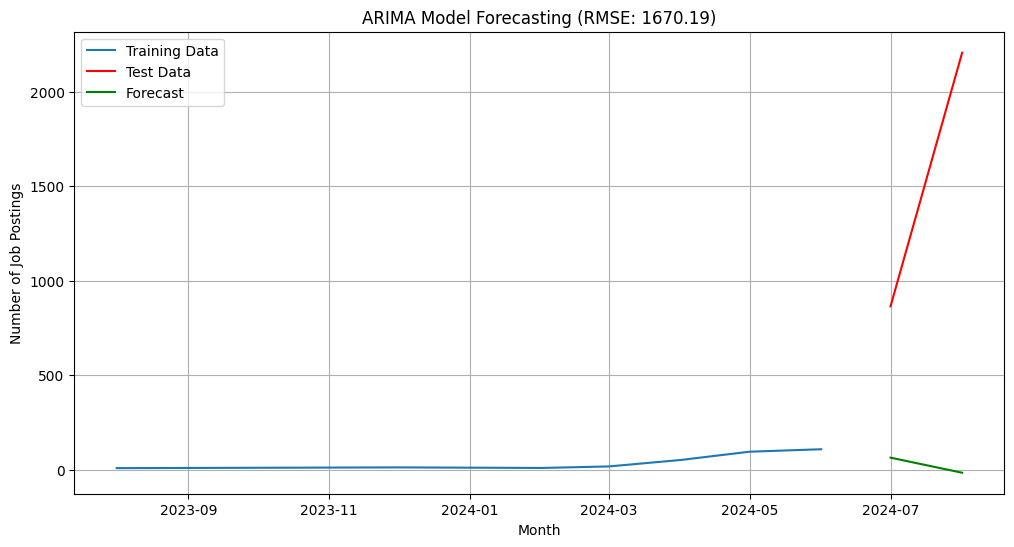

In [145]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Aggregate job postings by month to analyze trends over time
jobs_pd_df['job_posted_month'] = jobs_pd_df['job_posted_date'].dt.to_period('M')

# Aggregate the number of job postings by month
monthly_job_postings = jobs_pd_df.groupby('job_posted_month').size().reset_index(name='job_postings')

# Prepare the data for ARIMA model
monthly_job_postings.set_index('job_posted_month', inplace=True)
monthly_job_postings.index = monthly_job_postings.index.to_timestamp()

# Split data into training and testing sets
train_size = int(len(monthly_job_postings) * 0.8)
train, test = monthly_job_postings[:train_size], monthly_job_postings[train_size:]

# Fit the ARIMA model
model = ARIMA(train['job_postings'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast the future values
forecast = model_fit.forecast(steps=len(test))

# Calculate the mean squared error for the model
mse = mean_squared_error(test['job_postings'], forecast)
rmse = np.sqrt(mse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['job_postings'], label='Training Data')
plt.plot(test.index, test['job_postings'], label='Test Data', color='red')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title(f'ARIMA Model Forecasting (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Acer\AppData\Local\Temp\ipykernel_22992\3370700801.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  extended_dates = pd.date_range(start=test.index[-1] + pd.offsets.MonthBegin(1), periods=extended_forecast_steps, freq='M')


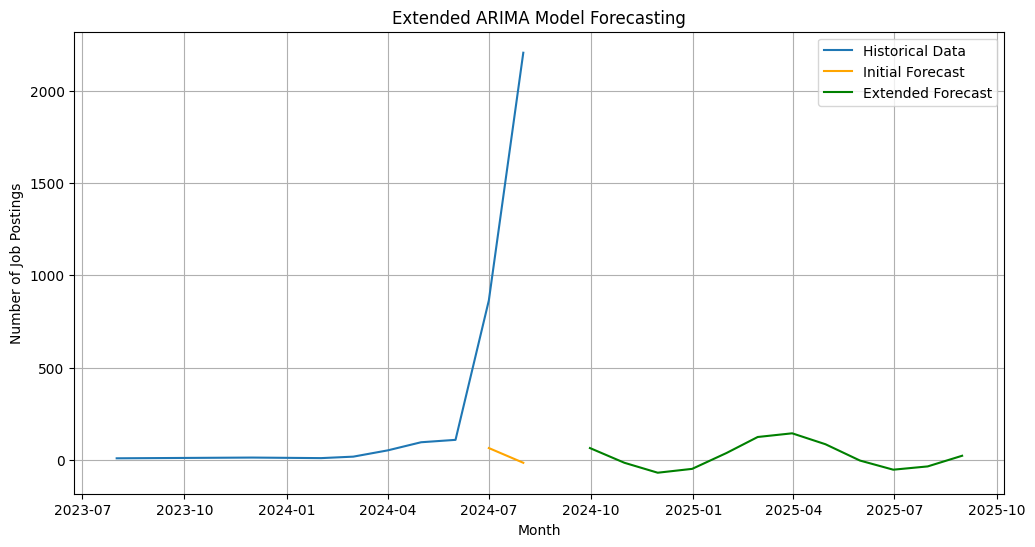

In [146]:
# Extend the forecast horizon
extended_forecast_steps = 12  # Forecast for the next 12 months
extended_forecast = model_fit.forecast(steps=extended_forecast_steps)

# Generate the dates for the extended forecast
extended_dates = pd.date_range(start=test.index[-1] + pd.offsets.MonthBegin(1), periods=extended_forecast_steps, freq='M')

# Plot the extended forecast along with the historical data
plt.figure(figsize=(12, 6))
plt.plot(monthly_job_postings.index, monthly_job_postings['job_postings'], label='Historical Data')
plt.plot(test.index, forecast, label='Initial Forecast', color='orange')
plt.plot(extended_dates, extended_forecast, label='Extended Forecast', color='green')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title('Extended ARIMA Model Forecasting')
plt.legend()
plt.grid(True)
plt.show()


### Prediction of Job Posting by Location (state and country)

Error fitting ARIMA model for  Alberta: too many indices for array: array is 0-dimensional, but 1 were indexed
Not enough data to fit ARIMA model for  Nova Scotia


C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


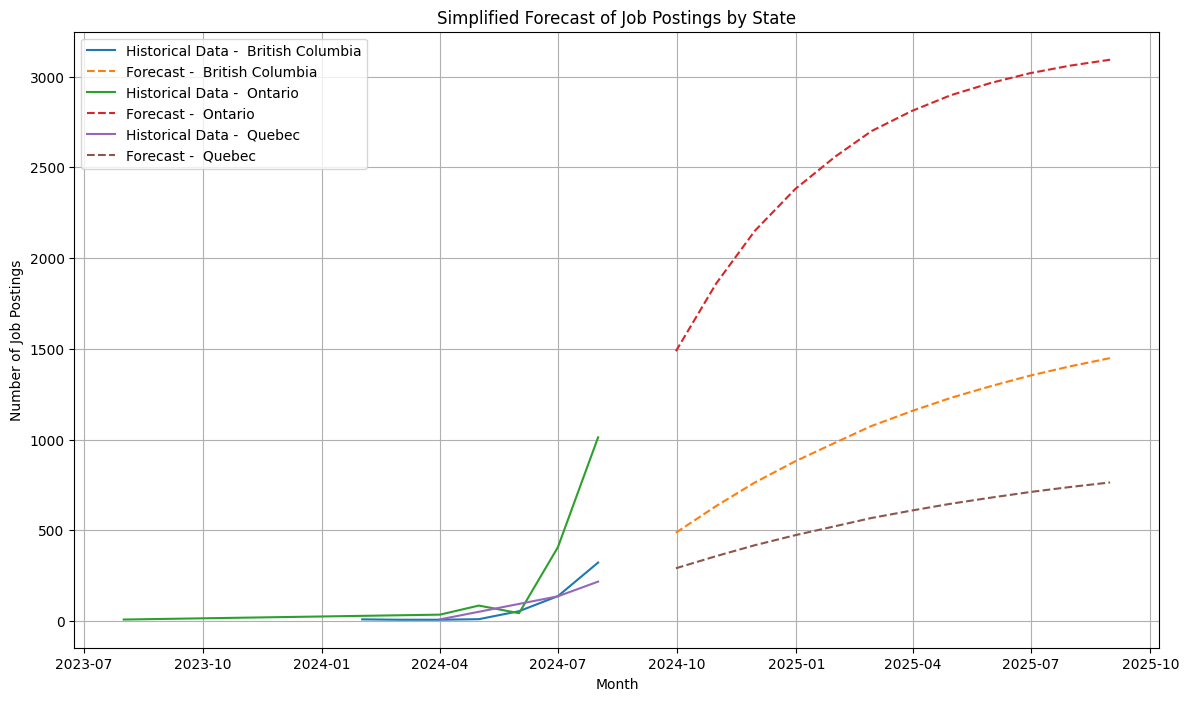

In [161]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.errors import EmptyDataError

# Extract the top 20 locations by the number of job postings
top_20_locations = jobs_pd_df['company_location'].value_counts().head(20).index

# Create a filtered dataset for these top 20 locations
top_20_location_data = jobs_pd_df[jobs_pd_df['company_location'].isin(top_20_locations)]

# Break down the locations into city, state, and country
location_details = top_20_location_data['company_location'].str.split(',', expand=True)
location_details.columns = ['city', 'state', 'country']
top_20_location_data = top_20_location_data.join(location_details)

# Summarize the number of job postings by location (state and country)
location_summary = top_20_location_data.groupby(['state', 'country']).size().reset_index(name='job_postings')

# Select the top 5 states based on the job postings
top_states = location_summary['state'].value_counts().head(5).index

# Simplify the ARIMA model by reducing the order to (1, 1, 0)
state_forecasts_simplified = {}

for state in top_states:
    # Filter the data for the specific state
    state_data = top_20_location_data[top_20_location_data['state'] == state]
    
    # Ensure job_posted_date is in datetime format
    state_data = state_data.copy()  # This avoids the SettingWithCopyWarning
    state_data['job_posted_date'] = pd.to_datetime(state_data['job_posted_date'])
    
    # Aggregate job postings by month
    state_monthly_postings = state_data.groupby(state_data['job_posted_date'].dt.to_period('M')).size()

    if len(state_monthly_postings) > 1:  # Ensure there's enough data for ARIMA
        try:
            # Train ARIMA model for this state with simplified parameters
            model = ARIMA(state_monthly_postings, order=(1, 1, 0))
            model_fit = model.fit()

            # Forecast for the next 12 months
            forecast = model_fit.forecast(steps=12)

            # Store the forecast
            state_forecasts_simplified[state] = (state_monthly_postings, forecast)
        except Exception as e:
            print(f"Error fitting ARIMA model for {state}: {e}")
    else:
        print(f"Not enough data to fit ARIMA model for {state}")

# Plot the forecasts for each state
plt.figure(figsize=(14, 8))

for state, (historical, forecast) in state_forecasts_simplified.items():
    # Plot historical data
    plt.plot(historical.index.to_timestamp(), historical, label=f'Historical Data - {state}')
    
    # Generate forecast dates
    forecast_dates = pd.date_range(start=historical.index[-1].to_timestamp() + pd.offsets.MonthBegin(1), periods=12, freq='ME')
    
    # Plot forecast data
    plt.plot(forecast_dates, forecast, label=f'Forecast - {state}', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title('Simplified Forecast of Job Postings by State')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Acer\AppData\Local\Temp\ipykernel_22992\2343362854.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=historical.index[-1].to_timestamp() + pd.offsets.MonthBegin(1), periods=12, freq='M')


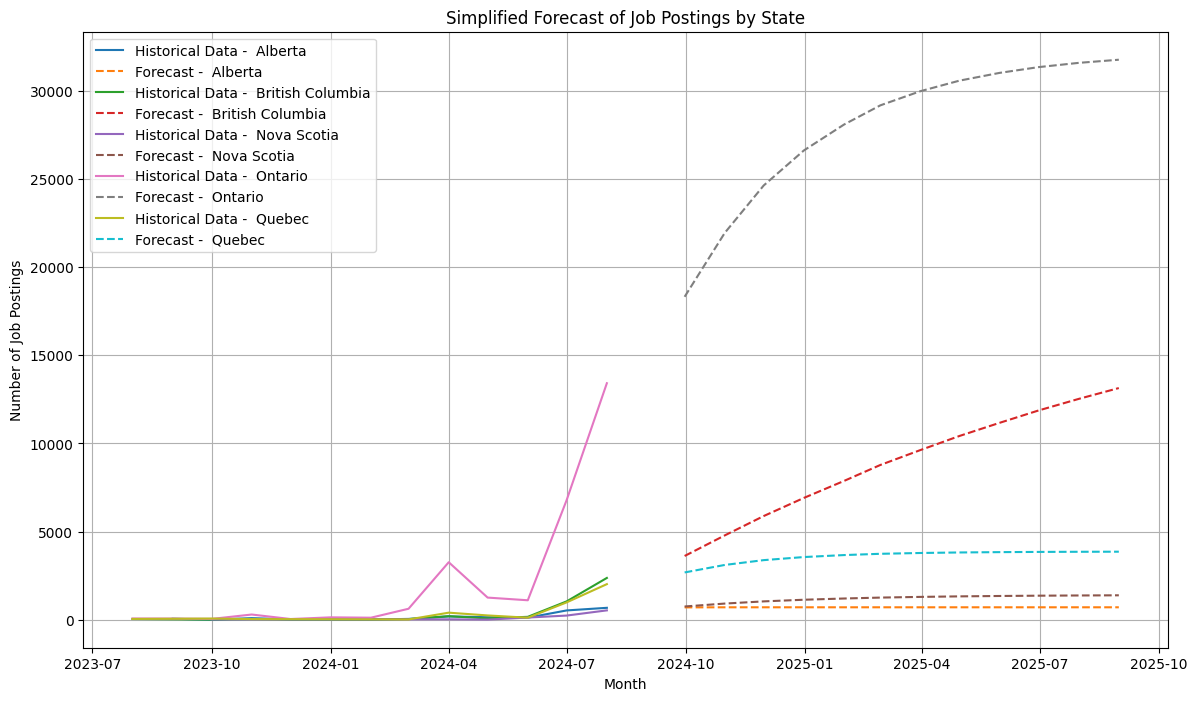

In [196]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Extract the top 10 locations by the number of job postings
top_10_locations = jobs_pd_df['company_location'].value_counts().head(10).index

# Create a filtered dataset for these top 10 locations
top_10_location_data = jobs_pd_df[jobs_pd_df['company_location'].isin(top_10_locations)]

# Break down the locations into city, state, and country
location_details = top_10_location_data['company_location'].str.split(',', expand=True)
location_details.columns = ['city', 'state', 'country']
top_10_location_data = top_10_location_data.join(location_details)

# Summarize the number of job postings by location (state and country)
location_summary = top_10_location_data.groupby(['state', 'country']).size().reset_index(name='job_postings')

# Select the top 5 states based on the job postings
top_states = location_summary['state'].value_counts().head(5).index

# Simplify the ARIMA model by reducing the order to (1, 1, 0)
state_forecasts_simplified = {}

for state in top_states:
    # Filter the data for the specific state
    state_data = top_10_location_data[top_10_location_data['state'] == state]
    
    # Ensure job_posted_date is in datetime format
    state_data = state_data.copy()  # This avoids the SettingWithCopyWarning
    state_data['job_posted_date'] = pd.to_datetime(state_data['job_posted_date'])
    
    # Aggregate job postings by month
    state_monthly_postings = state_data.groupby(state_data['job_posted_date'].dt.to_period('M')).size()

    if len(state_monthly_postings) > 1:  # Ensure there's enough data for ARIMA
        try:
            # Train ARIMA model for this state with simplified parameters
            model = ARIMA(state_monthly_postings, order=(1, 1, 0))
            model_fit = model.fit()

            # Forecast for the next 12 months
            forecast = model_fit.forecast(steps=12)

            # Store the forecast
            state_forecasts_simplified[state] = (state_monthly_postings, forecast)
        except Exception as e:
            print(f"Error fitting ARIMA model for {state}: {e}")
    else:
        print(f"Not enough data to fit ARIMA model for {state}")

# Plot the forecasts for each state
plt.figure(figsize=(14, 8))

for state, (historical, forecast) in state_forecasts_simplified.items():
    # Plot historical data
    plt.plot(historical.index.to_timestamp(), historical, label=f'Historical Data - {state}')
    
    # Generate forecast dates
    forecast_dates = pd.date_range(start=historical.index[-1].to_timestamp() + pd.offsets.MonthBegin(1), periods=12, freq='M')
    
    # Plot forecast data
    plt.plot(forecast_dates, forecast, label=f'Forecast - {state}', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title('Simplified Forecast of Job Postings by State')
plt.legend()
plt.grid(True)
plt.show()


### Accuracy of Prediction

In [197]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize lists to store the error metrics for each state
mae_list = []
rmse_list = []

# Calculate error metrics for each state
for state, (historical, forecast) in state_forecasts_simplified.items():
    # Assuming you have actual values to compare against for the forecast period
    # In this case, we'll just use the last few months of historical data as a stand-in
    actual = historical[-12:]  # Take the last 12 months of historical data

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, forecast[:len(actual)])
    rmse = np.sqrt(mean_squared_error(actual, forecast[:len(actual)]))
    
    # Store the results
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"State: {state}")
    print(f"  Mean Absolute Error (MAE): {mae}")
    print(f"  Root Mean Squared Error (RMSE): {rmse}\n")

# Overall MAE and RMSE
overall_mae = np.mean(mae_list)
overall_rmse = np.mean(rmse_list)

print(f"Overall Mean Absolute Error (MAE): {overall_mae}")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse}")


State:  Alberta
  Mean Absolute Error (MAE): 534.8700159814549
  Root Mean Squared Error (RMSE): 575.5536627712837

State:  British Columbia
  Mean Absolute Error (MAE): 8129.950258049812
  Root Mean Squared Error (RMSE): 8487.315448709294

State:  Nova Scotia
  Mean Absolute Error (MAE): 911.1125323489355
  Root Mean Squared Error (RMSE): 922.6878561038391

State:  Ontario
  Mean Absolute Error (MAE): 25650.217677289325
  Root Mean Squared Error (RMSE): 25967.80616453978

State:  Quebec
  Mean Absolute Error (MAE): 3145.525092825673
  Root Mean Squared Error (RMSE): 3193.5206578038237

Overall Mean Absolute Error (MAE): 7674.335115299039
Overall Root Mean Squared Error (RMSE): 7829.376757985605
